In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

,Extent,Date
0,1040455.516,1979-01-01
1,239334.118,1979-02-01
2,557365.154,1979-03-01
3,2054855.924,1979-04-01
4,2973925.625,1979-05-01
...,...,...
533,3137598.938,2023-06-01
534,3201783.453,2023-07-01
535,2973294.266,2023-08-01
536,3354839.711,2023-09-01


In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 6
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Ross_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((521, 12, 1), (521,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model_LT6/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 26s 336ms/step - loss: 0.3436 - root_mean_squared_error: 0.5861 - val_loss: 0.2106 - val_root_mean_squared_error: 0.4589
Epoch 2/50
53/53 [==============================] - 17s 332ms/step - loss: 0.1007 - root_mean_squared_error: 0.3174 - val_loss: 0.0734 - val_root_mean_squared_error: 0.2709
Epoch 3/50
53/53 [==============================] - 17s 320ms/step - loss: 0.0600 - root_mean_squared_error: 0.2449 - val_loss: 0.0703 - val_root_mean_squared_error: 0.2651
Epoch 4/50
53/53 [==============================] - 17s 329ms/step - loss: 0.0576 - root_mean_squared_error: 0.2400 - val_loss: 0.0668 - val_root_mean_squared_error: 0.2584
Epoch 5/50
53/53 [==============================] - 19s 358ms/step - loss: 0.0527 - root_mean_squared_error: 0.2296 - val_loss: 0.0615 - val_root_mean_squared_error: 0.2479
Epoch 6/50
53/53 [==============================] - 19s 355ms/step - loss: 0.0492 - root_mean_squared_error: 0.2217 - val_loss: 0.0550 

53/53 [==============================] - 17s 334ms/step - loss: 0.0067 - root_mean_squared_error: 0.0817 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0737
Epoch 29/50
53/53 [==============================] - 18s 347ms/step - loss: 0.0067 - root_mean_squared_error: 0.0820 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0718
Epoch 30/50
53/53 [==============================] - 18s 341ms/step - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0696
Epoch 31/50
53/53 [==============================] - 17s 335ms/step - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0691
Epoch 32/50
53/53 [==============================] - 18s 342ms/step - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0680
Epoch 33/50
53/53 [==============================] - 3s 56ms/step - loss: 0.0064 - root_mean_squared_error: 0.0800 - val_loss: 0.0055 - val_ro

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

10.149098261197407 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

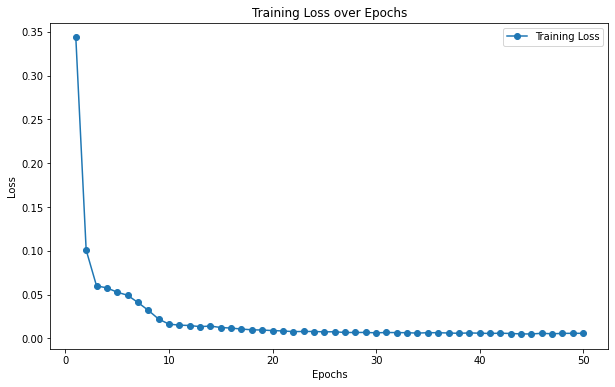

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

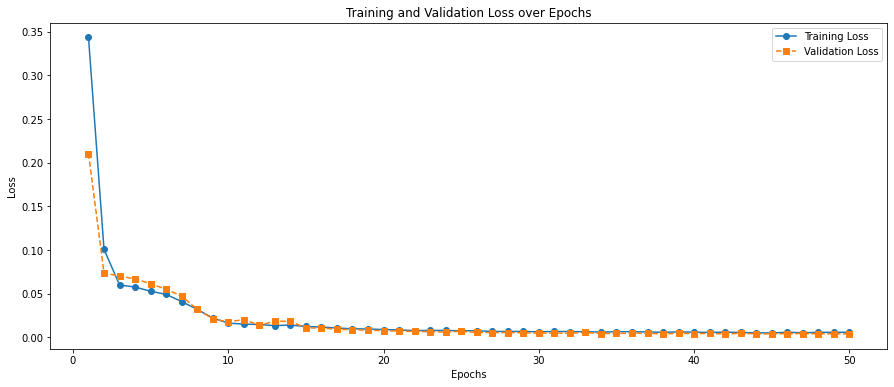

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model_LT6/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 29ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.08571495692517846
MAE : 0.06502120811430585


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,3.809694e+06,3909211.179
1,3.318020e+06,3499167.351
2,2.333830e+06,2715890.297
3,8.872001e+05,1053272.694
4,2.535890e+05,368862.123
5,9.123383e+05,979418.298
6,1.884283e+06,2086269.569
7,2.680144e+06,2852731.016
8,3.101618e+06,3452823.613
9,3.418402e+06,3846843.974


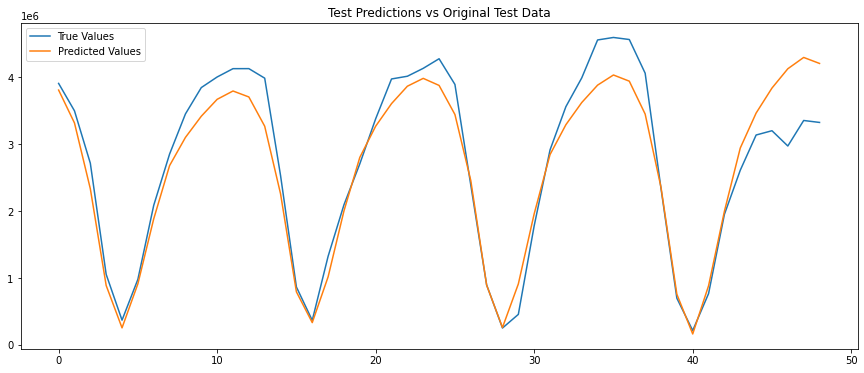

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 28ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

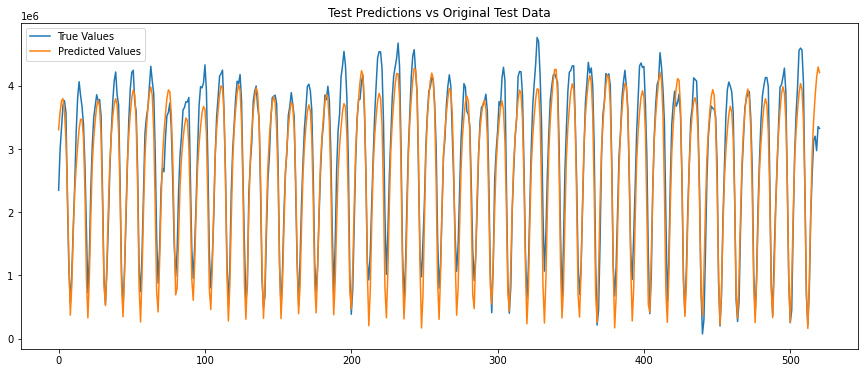

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()